# Trabajo Práctico N°2: Modelo de predicción de precios de propiedades 

## Desafío 2. Modelo para el calculo del precio aproximado en USD de las  propiedades

Grupo Nª2
Alumnos:
* Alberto Paparelli
* André Song
* Marianela Riz
* Gloria Caravajal
* Franco Emanuel Rodriguez

Objetivos:
● Seleccionar los datos a modelar. Justificar esa selección.
● Entrenar al menos tres modelos de regresión lineal distintos sobre estos datos.
● Evaluar la performance de los modelos y comparar ventajas y desventajas de cada
uno.
● Determinar la importancia de las features incluidas en la predicción. Interpretar.

# Modelo a desarrollar

 Modelo para apartamentos usadas de Capital Federal


# Importación de librerias

In [41]:
#importamos librerias para tratamiento de datos
import numpy as np
import pandas as pd
import re
import math as mat

#importamos librerias la visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
%matplotlib inline




## Cargue del Dataframe de Capital Federal

Hemos seleccionado este State_name porqué aunque con la limpieza se perdieron algunos datos, sigue teniendo una cantidad importante de datos.
Adicionalmente, estos datos ya traen consigo la información en los Place_name de los barrios de la Capital Federal, que puede ser una variable explicativa del precio del metro cuadrado de las propiedades.

In [42]:
filename = "../dataset/capital.csv"
data_original = pd.read_csv(filename, sep=',')
display(data_original.sample(n=2))
print(f"(Cantidad de Filas, Cantidad de columnas) -> {data_original.shape}")

,Unnamed: 0,numero,property_type,place_name,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,description,title
5748,5748,5749,apartment,Barracas,23308385,132100,56,51,2359,2590,3,2,0,1,1,0,1,"Departamento a estrenar, entrega inmediata!Tod...",Av. Regimiento de Patricios 330 - Barracas - 2...
7928,7928,7929,apartment,Belgrano,2893698,164000,55,48,2982,3417,1,2,0,1,1,1,1,"Se trata de un edificio en Belgrano, en una zo...",Departamento - Belgrano


(Cantidad de Filas, Cantidad de columnas) -> (16938, 19)


In [43]:

data=data_original[(data_original.property_type=='apartment') & (data_original.nuevo==0) &(data_original.price_aprox_usd<800000)
 & (data_original.surface_total_in_m2<500) & (data_original.surface_covered_in_m2<500) & (data_original.rooms>=1) 
 &(data_original.floor>=1) & (data_original.place_name=='Palermo')]
display(data.sample(2))
data.shape

,Unnamed: 0,numero,property_type,place_name,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,description,title
9600,9600,9601,apartment,Palermo,12704040,720000,157,139,4586,5180,2,4,0,1,0,1,0,Excelente departamento ubicado en una de las m...,Sinclair 3000 - Palermo - Capital Federal
9124,9124,9125,apartment,Palermo,4234680,240000,62,53,3871,4528,2,2,0,1,0,1,0,Excelente departamento de 2 amb. Arquitectura ...,Departamento 2 amb venta en Las Cañitas c- ren...


(633, 19)

Vamos a eliminar las columnas que no vamos a emplear para desarrollar los modelos: Description y Title

In [44]:
data.drop([data.columns[0],"numero","description","price_aprox_local_currency","price_per_m2" ,"title", "property_type"], axis=1,inplace=True)
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 276 to 16924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   place_name             633 non-null    object
 1   price_aprox_usd        633 non-null    int64 
 2   surface_total_in_m2    633 non-null    int64 
 3   surface_covered_in_m2  633 non-null    int64 
 4   price_usd_per_m2       633 non-null    int64 
 5   floor                  633 non-null    int64 
 6   rooms                  633 non-null    int64 
 7   expenses               633 non-null    int64 
 8   piscina                633 non-null    int64 
 9   Parrilla               633 non-null    int64 
 10  Cochera                633 non-null    int64 
 11  nuevo                  633 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 64.3+ KB


c:\Users\usuario\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Creamos un grupo de variables númericas empleando. describe, tambien chequemos los valores minimos y máximos de las variables.

In [45]:
num=data.describe()
num

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.0
mean,279526.183254,89.791469,79.766193,3165.086888,2.998420,2.887836,20560.853081,0.246445,0.213270,0.374408,0.0
std,171124.308198,50.508560,43.250547,1134.517492,2.035678,1.101665,32382.038708,0.431282,0.409941,0.484352,0.0
min,64000.000000,13.000000,17.000000,1132.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,145600.000000,50.000000,45.000000,2541.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,236060.000000,80.000000,72.000000,2944.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,360000.000000,115.000000,100.000000,3500.000000,4.000000,4.000000,29000.000000,0.000000,0.000000,1.000000,0.0
max,790000.000000,309.000000,260.000000,19231.000000,14.000000,7.000000,200000.000000,1.000000,1.000000,1.000000,0.0


Una vez tenemos una base limpia, sacamos una matriz de correlación para observar el comportamiento entre variables

In [46]:
data.corr()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
price_aprox_usd,1.000000,0.831746,0.841170,0.371861,0.082419,0.613832,0.389529,0.282960,0.170043,0.515766,NaN
surface_total_in_m2,0.831746,1.000000,0.946594,-0.081688,0.098271,0.721853,0.417242,0.065557,0.141767,0.386478,NaN
surface_covered_in_m2,0.841170,0.946594,1.000000,0.003980,0.094777,0.757951,0.426583,0.052293,0.063948,0.387736,NaN
price_usd_per_m2,0.371861,-0.081688,0.003980,1.000000,-0.042433,-0.063473,0.022472,0.376785,0.096489,0.352588,NaN
floor,0.082419,0.098271,0.094777,-0.042433,1.000000,0.128330,0.113457,-0.129317,-0.067854,0.048744,NaN
rooms,0.613832,0.721853,0.757951,-0.063473,0.128330,1.000000,0.243800,-0.128221,-0.094099,0.238955,NaN
expenses,0.389529,0.417242,0.426583,0.022472,0.113457,0.243800,1.000000,0.041295,0.011913,0.274520,NaN
piscina,0.282960,0.065557,0.052293,0.376785,-0.129317,-0.128221,0.041295,1.000000,0.498757,0.375643,NaN
Parrilla,0.170043,0.141767,0.063948,0.096489,-0.067854,-0.094099,0.011913,0.498757,1.000000,0.314414,NaN
Cochera,0.515766,0.386478,0.387736,0.352588,0.048744,0.238955,0.274520,0.375643,0.314414,1.000000,NaN


Graficamos un mapa de calor para identificar cuales son las variables numericas que se relacionan más con el precio por metro cuadrado en dolares
Asi podemos ver que los datos que más se relacionan son: 

Text(0.5, 1.0, 'Heatmap')

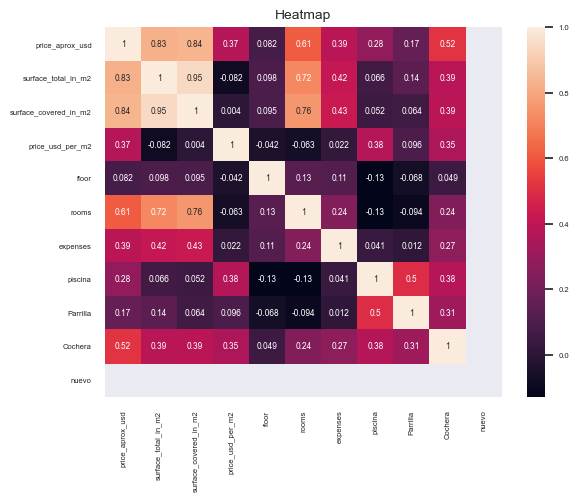

In [47]:
corr=data.corr()
sns.set(font_scale=0.5)
sns.heatmap(corr,annot=True)
plt.title("Heatmap",fontsize=10)

Ahora creamos un grupo de variables categoricas empleando. describe de tipo Object.

In [48]:
cat=data.describe(include=[object])  
cat

,place_name
count,633
unique,1
top,Palermo
freq,633


Calculamos la media de las variables numericas tomando como base las variables **categoricas y las organizamos para poder hacer un analisis general
Lo que podemos ver en este analisis es que  ***por ejemplo que :xxx**

In [49]:
grpmean=data.groupby(list(cat.columns)).mean().sort_values(by=['place_name'])
grpmean[['price_aprox_usd', 'price_usd_per_m2','surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'expenses', 'piscina', 'Parrilla', 'Cochera', 'nuevo']]

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,surface_covered_in_m2,floor,expenses,piscina,Parrilla,Cochera,nuevo
place_name,,,,,,,,,,
Palermo,279526.183254,3165.086888,89.791469,79.766193,2.99842,20560.853081,0.246445,0.21327,0.374408,0.0


Tambien chequeamos cuantos datos tenemos en esa distribución

In [50]:
data.groupby(list(cat.columns)).count()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
place_name,,,,,,,,,,,
Palermo,633,633,633,633,633,633,633,633,633,633,633


In [51]:
num.columns

Index(['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'piscina', 'Parrilla',
       'Cochera', 'nuevo'],
      dtype='object')

Generamos variables dummies 

In [52]:
datadum=pd.get_dummies(data)
datadum.columns

Index(['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'piscina', 'Parrilla',
       'Cochera', 'nuevo', 'place_name_Palermo'],
      dtype='object')

In [53]:
datadum.head()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,place_name_Palermo
276,93000,62,32,1500,1,1,19000,0,0,0,0,1
406,270000,160,120,1688,1,4,0,0,1,0,0,1
693,120000,60,50,2000,3,2,15000,0,0,0,0,1
697,120000,60,55,2000,3,3,0,0,0,0,0,1
785,165000,80,78,2063,3,3,0,0,0,0,0,1


# Modelo 2

Para el segundo modelo emplearemos la base de datos de los apartamentos usados de capital federal y emplearemos las features surface_total_in_m2, surface_covered_in_m2 y rooms porque presentan una mayor correlación con price_aprox_usd

In [63]:
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera']

featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera' ,'floor', 'expenses', 'piscina', 'Parrilla']
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'Cochera','piscina']

X=datadum[featcol]
y=datadum[['price_aprox_usd']]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=123)



In [64]:
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera']
featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera' ,'floor', 'expenses', 'piscina', 'Parrilla']
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'Cochera','piscina']

X=Xtrain[featcol]
y=ytrain

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model_1= sm.OLS(y, X).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     216.8
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          1.34e-151
Time:                        10:33:21   Log-Likelihood:                -6023.0
No. Observations:                 474   AIC:                         1.206e+04
Df Residuals:                     465   BIC:                         1.210e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.434e+

In [28]:
featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms','place_name_Abasto', 'place_name_Agronomía',
       'place_name_Almagro', 'place_name_Balvanera', 'place_name_Barracas',
       'place_name_Barrio Norte', 'place_name_Belgrano', 'place_name_Boca',
       'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Catalinas',
       'place_name_Centro / Microcentro', 'place_name_Chacarita',
       'place_name_Coghlan', 'place_name_Colegiales', 'place_name_Congreso',
       'place_name_Constitución', 'place_name_Flores', 'place_name_Floresta',
       'place_name_Las Cañitas', 'place_name_Liniers', 'place_name_Mataderos',
       'place_name_Monserrat', 'place_name_Monte Castro', 'place_name_Nuñez',
       'place_name_Once', 'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Palermo Soho',
       'place_name_Palermo Viejo', 'place_name_Parque Avellaneda',
       'place_name_Parque Centenario', 'place_name_Parque Chacabuco',
       'place_name_Parque Chas', 'place_name_Parque Patricios',
       'place_name_Paternal', 'place_name_Pompeya', 'place_name_Puerto Madero',
       'place_name_Recoleta', 'place_name_Retiro', 'place_name_Saavedra',
       'place_name_San Cristobal', 'place_name_San Nicolás',
       'place_name_San Telmo', 'place_name_Tribunales',
       'place_name_Velez Sarsfield', 'place_name_Versalles',
       'place_name_Villa Crespo', 'place_name_Villa Devoto',
       'place_name_Villa General Mitre', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Ortuzar',
       'place_name_Villa Pueyrredón', 'place_name_Villa Real',
       'place_name_Villa Santa Rita', 'place_name_Villa Soldati',
       'place_name_Villa Urquiza', 'place_name_Villa del Parque']


Xtrain_sklearn = Xtrain[featcol]

model_1 = LinearRegression(fit_intercept=True)

model_1.fit(Xtrain_sklearn, ytrain)

print(model_1.coef_)

print(model_1.intercept_)

[[ 7.75404259e+02  1.61458273e+03 -3.78722352e+03 -2.39564263e+04
  -1.56472211e+04  8.97459311e+03 -5.00728849e+04 -3.78941556e+04
   4.48233085e+04  4.39426402e+04 -3.23943142e+04  2.33143054e+05
  -1.16733922e+03 -1.24762983e+04 -1.54455064e+05 -2.46666065e+04
  -1.75797573e+04 -5.93011321e+03  2.02897808e+03 -4.63399481e+04
  -3.24882424e+04 -2.01875782e+04 -4.76854115e+04  8.19934353e+04
  -3.63492745e+04 -4.52648151e+04 -5.13647275e+04 -6.09786344e+04
   3.18777662e+04 -5.43738529e+04  7.01388149e+04  1.54084131e+05
   3.82643583e+04  4.55809033e+04  9.41037701e+04 -5.95754334e+04
  -1.77760452e+04 -2.59777814e+04 -1.46973605e+04 -1.20793301e+04
   1.83148943e+05 -1.15457231e+05  2.28960333e+05  8.44499450e+04
   2.46814266e+04 -2.49384146e+03  1.26274860e+05 -2.82945250e+04
   7.22860748e+04 -5.98683978e+04 -1.35465060e+04 -4.30886934e+04
  -4.69830424e+03 -3.31749182e+03 -3.38474753e+04 -9.86340581e+04
  -1.30429362e+04 -1.02708887e+04 -1.47546460e+04 -2.55194470e+04
  -3.70298

In [29]:
print("R2: ", model_1.score(Xtrain_sklearn, ytrain))

n = len(ytrain)
p = 5
ypred_train = model_1.predict(Xtrain_sklearn)
r2 = metrics.r2_score(ytrain, ypred_train)
r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))

print("R2: ", metrics.r2_score(ytrain, ypred_train))
print("R2 ajustado: ", r2_ajustado)
print('Mean Absolute Error:', metrics.mean_absolute_error(ytrain, ypred_train))
print('Mean Squared Error:', metrics.mean_squared_error(ytrain, ypred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrain, ypred_train)))

R2:  0.4930584403814401
R2:  0.4930584403814401
R2 ajustado:  0.4928002183156197
Mean Absolute Error: 64311.14975294392
Mean Squared Error: 12616597044.057705
Root Mean Squared Error: 112323.62638402352


In [30]:
Xtest_sklearn = Xtest[featcol]

print("R2: ", model_1.score(Xtest_sklearn, ytest))

n = len(ytest)
p = 5
ypred_test = model_1.predict(Xtest_sklearn)
r2 = metrics.r2_score(ytest, ypred_test)
r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))

print("R2: ", metrics.r2_score(ytest, ypred_test))
print("R2 ajustado: ", r2_ajustado)
print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, ypred_test))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, ypred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred_test)))

R2:  0.5308764427281429
R2:  0.5308764427281429
R2 ajustado:  0.5301586894275434
Mean Absolute Error: 62165.430317682505
Mean Squared Error: 11458303244.232285
Root Mean Squared Error: 107043.46427611676
